In [ ]:
!pip -q install --no-deps transformer-lens==2.15.4
!pip -q install datasets==2.19.1 fsspec==2024.3.1 gcsfs==2024.3.1
!pip -q install jaxtyping==0.3.1 typeguard==4.2.0 beartype==0.14.1 \
                 better-abc==0.0.3 fancy-einsum==0.0.3 \
                 transformers-stream-generator==0.0.5

In [ ]:
!pip uninstall -y transformers transformers-stream-generator -q || true
!pip install -q transformers==4.40.2 transformers-stream-generator==0.0.5

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformer-lens 2.15.4 requires transformers>=4.43, but you have transformers 4.40.2 which is incompatible.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.40.2 which is incompatible.


In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt, pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "gpt2-xl"
tokenizer  = GPT2Tokenizer.from_pretrained(model_name)
model      = GPT2LMHeadModel.from_pretrained(model_name).to(device).eval()
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("Loaded GPT‑2 XL | Layers:", model.config.n_layer)
W_E = model.transformer.wte.weight

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded GPT‑2 XL | Layers: 48


Total subjects: 1195


100%|██████████| 1195/1195 [01:41<00:00, 11.72it/s]


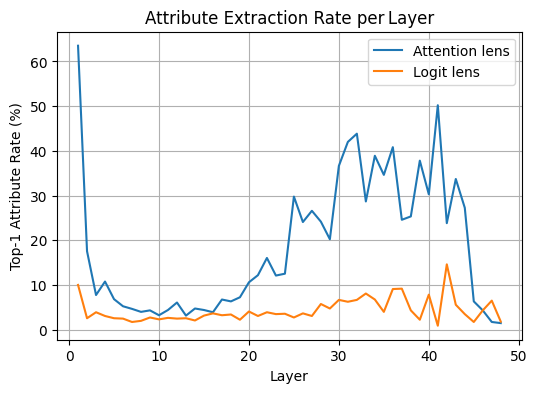

In [ ]:
wiki_path = "/content/drive/MyDrive/AttentionLens/data/wiki.pickle"
df_wiki   = pd.read_pickle(wiki_path)[["subject", "context_tokenized_dedup_no-stopwords"]]
df_wiki["context_set"] = df_wiki["context_tokenized_dedup_no-stopwords"] \
                           .apply(lambda toks: set(map(str.lower, map(str.strip, toks))))
print("Total subjects:", len(df_wiki))

num_layers  = model.config.n_layer
attn_hits   = np.zeros(num_layers, dtype=int)
mlp_hits    = np.zeros(num_layers, dtype=int)
total_cases = 0

def hook_attn(l, pos):
    def _hook(m, _inp, out):
        attn_vec = out[0] if isinstance(out, tuple) else out
        acts[f"attn_{l}"] = attn_vec[:, pos, :].detach()
    return _hook

def hook_mlp(l, pos):
    def _hook(m, _inp, out):
        mlp_out = out[0] if isinstance(out, tuple) else out
        acts[f"mlp_{l}"] = mlp_out[:, pos, :].detach()
    return _hook

for _, row in tqdm(df_wiki.iterrows(), total=len(df_wiki)):
    subj, ctx_set = row.subject, row.context_set
    if not ctx_set:
        continue
    prompt = f"{subj} is known for"
    ids    = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    tokens = tokenizer.convert_ids_to_tokens(ids[0])

    subj_ids = tokenizer(subj, add_special_tokens=False).input_ids
    try:
        start = next(i for i in range(len(tokens)-len(subj_ids)+1)
                     if tokens[i:i+len(subj_ids)] ==
                        tokenizer.convert_ids_to_tokens(subj_ids))
    except StopIteration:
        continue
    last_idx = start + len(subj_ids) - 1

    acts, hooks = {}, []
    for l in range(num_layers):
        hooks += [
            model.transformer.h[l].attn.register_forward_hook(hook_attn(l, last_idx)),
            model.transformer.h[l].mlp .register_forward_hook(hook_mlp (l, last_idx)),
        ]
    with torch.no_grad(): _ = model(ids)
    for h in hooks: h.remove()

    ctx_lower = ctx_set
    for l in range(num_layers):
        logits_a = acts[f"attn_{l}"] @ W_E.T
        top_tok  = tokenizer.decode(int(logits_a.argmax(-1))).strip().lower()
        if top_tok in ctx_lower:
            attn_hits[l] += 1

        logits_m = acts[f"mlp_{l}"] @ W_E.T
        top_tok2 = tokenizer.decode(int(logits_m.argmax(-1))).strip().lower()
        if top_tok2 in ctx_lower:
            mlp_hits[l] += 1
    total_cases += 1

attn_rate = attn_hits / total_cases * 100
mlp_rate  = mlp_hits  / total_cases * 100

plt.figure(figsize=(6,4))
plt.plot(range(1, num_layers+1), attn_rate, label="Attention lens")
plt.plot(range(1, num_layers+1), mlp_rate,  label="Logit lens")
plt.xlabel("Layer"); plt.ylabel("Top‑1 Attribute Rate (%)")
plt.title("Attribute Extraction Rate per Layer")
plt.legend(); plt.grid(True); plt.show()

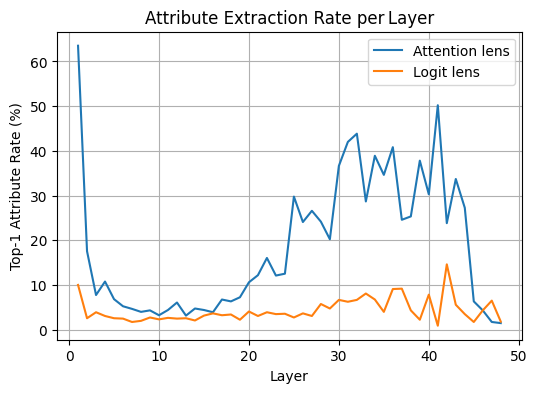

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(range(1, num_layers+1), attn_rate, label="Attention lens")
plt.plot(range(1, num_layers+1), mlp_rate,  label="Logit lens")
plt.xlabel("Layer"); plt.ylabel("Top‑1 Attribute Rate (%)")
plt.title("Attribute Extraction Rate per Layer")
plt.legend(); plt.grid(True); plt.show()

In [ ]:
def _subject_variants(subject, tok):
    ids0 = tok(subject, add_special_tokens=False).input_ids
    ids1 = tok(" " + subject, add_special_tokens=False).input_ids
    return [ids0, ids1]

def _find_last_idx(input_ids, variants):
    seq_len = input_ids.size(1)
    for var in variants:
        n = len(var)
        if n > seq_len:
            continue
        for i in range(seq_len - n + 1):
            if torch.equal(input_ids[0, i:i+n],
                           torch.tensor(var, device=input_ids.device)):
                return i + n - 1
    return None

def patch_curve(model, tok, prompt_tpl, subject, attr_token,
                lambdas=torch.linspace(-3, 3, 13, device=device),
                k_detect=8):

    prompt = prompt_tpl.format(subject)
    toks   = tok(prompt, return_tensors="pt").to(device)

    subj_last = _find_last_idx(
        toks.input_ids, _subject_variants(subject, tok)
    )
    if subj_last is None:
        print(f"Subject not found: {subject}"); return None,None,None

    cache = {}
    def mk_hook(l):
        def _hook(_,__,out):
            hid = out[0] if isinstance(out, tuple) else out
            cache[l] = hid[:, subj_last, :].detach()
        return _hook
    hs = [model.transformer.h[l].attn.register_forward_hook(mk_hook(l))
          for l in range(model.config.n_layer)]
    with torch.no_grad(): _ = model(**toks)
    for h in hs: h.remove()


    attr_id = tok(" " + attr_token, add_special_tokens=False).input_ids[-1]
    extract = next(
        (l for l in range(model.config.n_layer)
         if attr_id in (cache[l] @ W_E.T).topk(k_detect).indices),
        None
    )
    if extract is None:
        print(f"Failed to find extraction layer for: {subject}→{attr_token}")
        return None,None,None

    resid = {}
    def pull(_,__,out):
        hid = out[0] if isinstance(out, tuple) else out
        resid["h0"] = hid[:, subj_last, :].detach()
    hres = model.transformer.h[extract].register_forward_hook(pull)
    with torch.no_grad(): _ = model(**toks)
    hres.remove()
    h0    = resid["h0"].squeeze(0)
    sigma = h0.std()
    u     = model.transformer.wte.weight[attr_id]
    u     = u / u.norm()

    base = model(**toks).logits[0, -1, attr_id].item()
    delta = []
    for lam in lambdas:
        def patch_fn(_,__,out):
            hid, *rest = out if isinstance(out, tuple) else (out,)
            hid = hid.clone()
            hid[0, subj_last, :] = h0 + lam * sigma * u
            return (hid, *rest) if rest else hid
        hp = model.transformer.h[extract].register_forward_hook(patch_fn)
        with torch.no_grad():
            logit = model(**toks).logits[0, -1, attr_id].item()
        hp.remove()
        delta.append(logit - base)
    return lambdas.cpu(), torch.tensor(delta).cpu(), extract



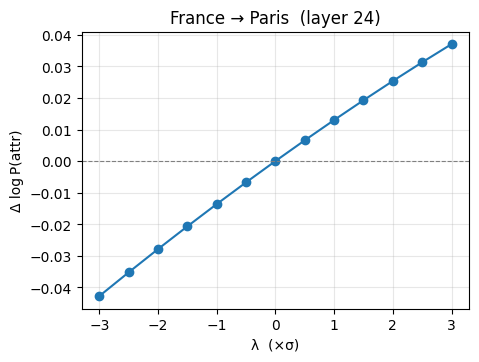

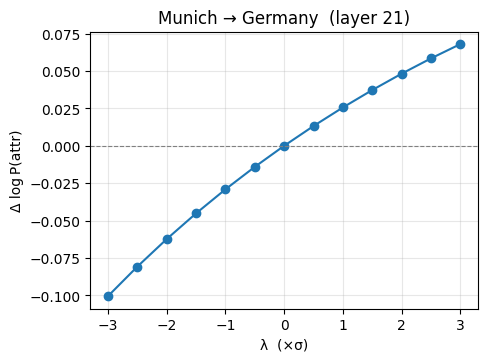

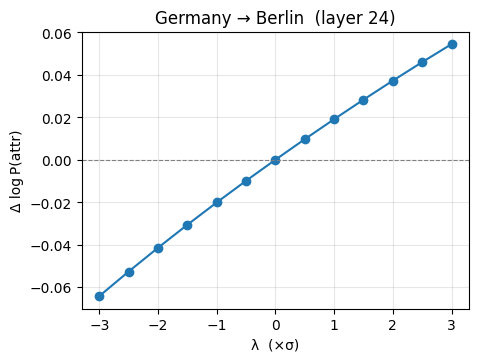

In [ ]:
examples = [
    ("The capital of {} is", "France",  "Paris"),
    ("{} is a city in",      "Munich",  "Germany"),
    ("The capital of {} is", "Germany", "Berlin"),
]

for tpl, subj, attr in examples:
    xs, ys, layer = patch_curve(model, tokenizer, tpl, subj, attr)
    if xs is None: continue
    plt.figure(figsize=(5,3.6))
    plt.plot(xs, ys, marker='o')
    plt.axhline(0, color='gray', ls='--', lw=.8)
    plt.title(f"{subj} → {attr}  (layer {layer})")
    plt.xlabel(r"λ  (×σ)")
    plt.ylabel("Δ log P(attr)")
    plt.grid(True, alpha=.3)
    plt.show()


In [ ]:
    plt.savefig(f"patch_{subj.replace(' ','_')}_{attr}.png", dpi=150, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>